In [3]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch.nn.functional as F
import torchvision.transforms as transforms
import pickle

from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, accuracy_score

from galaxy_dataset import GalaxyDataset

from models.simple_cnn import SimpleCNN
from models.powerful_cnn import PowerfulCNN
from models.efficient_net import create_efficientnet

In [16]:
# Utility to load images and labels
def load_data(h5_file='data/Galaxy10_DECals.h5'):
    with h5py.File(h5_file, 'r') as F:
        images = np.array(F['images'])
        labels = np.array(F['ans'])
    return images, labels

# Create train/val/test splits
def create_splits(dataset, seed=42):
    dataset_size = len(dataset)
    train_size = int(0.7 * dataset_size)
    val_size = int(0.15 * dataset_size)
    test_size = dataset_size - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(seed)
    )
    return train_dataset, val_dataset, test_dataset

# Build test_loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
images, labels = load_data()
dataset = GalaxyDataset(images, labels, transform=transform)  # no transform for test, or use your standard transforms

train_dataset, val_dataset, test_dataset = create_splits(dataset, seed=42)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

print("Test set size:", len(test_dataset))

Test set size: 2661


In [3]:
# === Single Confusion Matrix ===
model_path = 'trained_models/best_powerful_cnn_raw.pth'  # Adjust if necessary
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Initialize the model
model = PowerfulCNN(num_classes=10).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Gather predictions and ground truths
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels_batch in test_loader:
        inputs = inputs.to(device)
        labels_batch = labels_batch.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy().tolist())
        all_labels.extend(labels_batch.cpu().numpy().tolist())

# Pickle save predictions and labels
with open('predictions.pkl', 'wb') as f:
    pickle.dump(all_preds, f)
with open('labels.pkl', 'wb') as f:
    pickle.dump(all_labels, f)

Test Accuracy: 0.7388
Test Accuracy: 0.7388


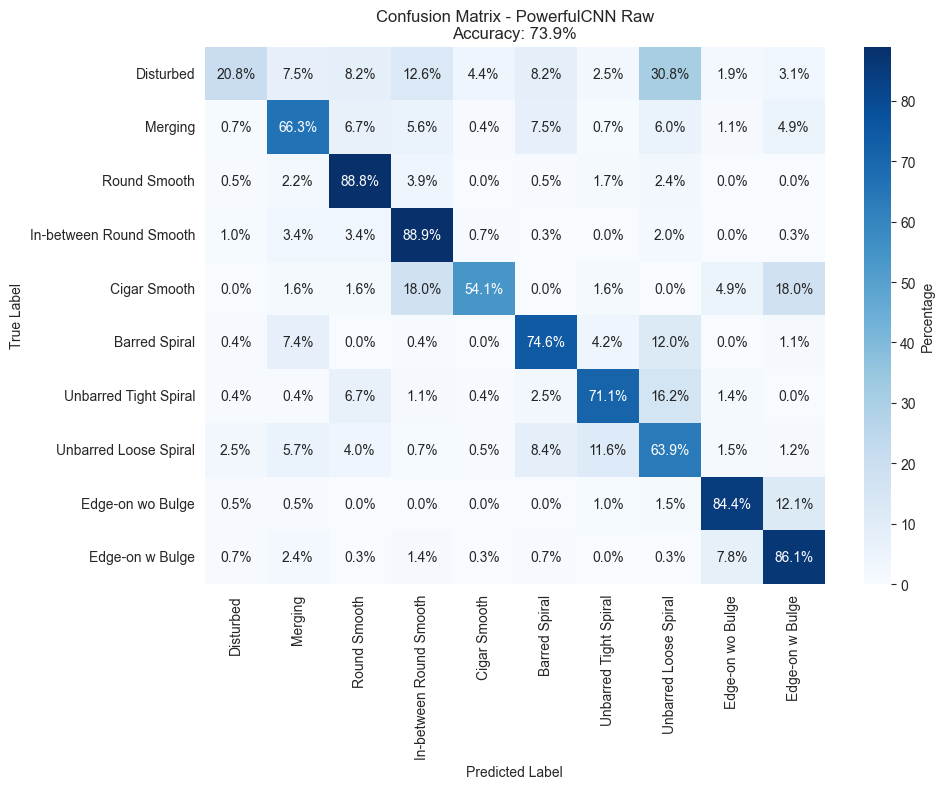

In [12]:
# Load predictions and labels
with open('predictions.pkl', 'rb') as f:
    all_preds = pickle.load(f)
with open('labels.pkl', 'rb') as f:
    all_labels = pickle.load(f)

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

classes = ['Disturbed', 'Merging', 'Round Smooth', 'In-between Round Smooth', 
           'Cigar Smooth', 'Barred Spiral', 'Unbarred Tight Spiral', 
           'Unbarred Loose Spiral', 'Edge-on wo Bulge', 'Edge-on w Bulge']

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute the confusion matrix (absolute counts)
cm = confusion_matrix(all_labels, all_preds)

# Normalize by row (true labels) so that each row sums to 100
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
cm_percent = cm_normalized * 100
annot = np.array([["{:.1f}%".format(cell) for cell in row] for row in cm_percent])

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10,8))
sns.heatmap(cm_percent, annot=annot, fmt="", cmap="Blues",
            xticklabels=classes, yticklabels=classes, cbar_kws={'label': 'Percentage'})
plt.title(f"Confusion Matrix - PowerfulCNN Raw\nAccuracy: {accuracy*100:.1f}%")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

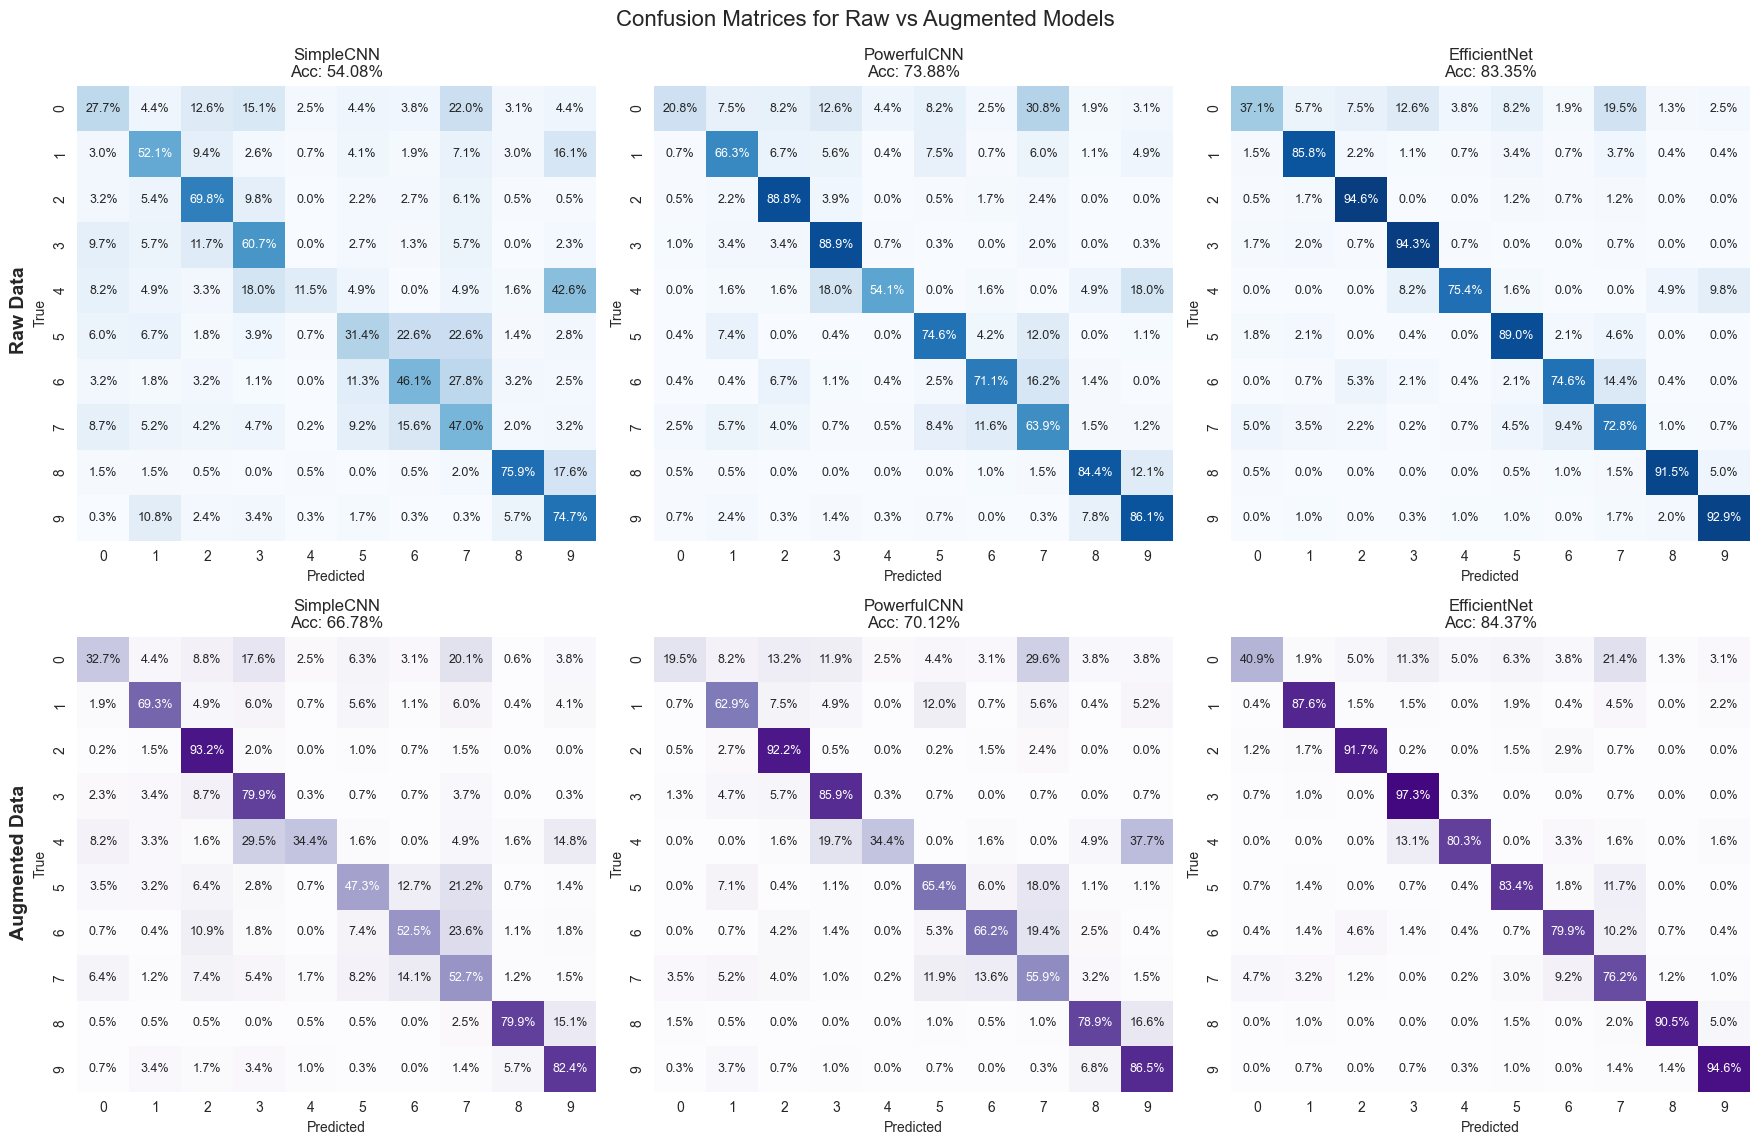

In [40]:
def evaluate_model_with_pickle(model, model_path, test_loader, device, pickle_name):
    """
    Load predictions from a pickle file if available,
    otherwise perform inference and save to pickle.
    """
    if os.path.exists(pickle_name):
        with open(pickle_name, 'rb') as f:
            data = pickle.load(f)
        return data['all_labels'], data['all_preds'], data['accuracy']
    else:
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels_batch in test_loader:
                inputs = inputs.to(device)
                labels_batch = labels_batch.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels_batch.cpu().numpy())
        accuracy = accuracy_score(all_labels, all_preds)
        data = {'all_labels': all_labels, 'all_preds': all_preds, 'accuracy': accuracy}
        os.makedirs("predictions", exist_ok=True)
        with open(pickle_name, 'wb') as f:
            pickle.dump(data, f)
        return all_labels, all_preds, accuracy

# Device selection
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Model checkpoint paths 
model_paths = {
    "SimpleCNN_raw": "trained_models/best_simple_cnn_raw.pth",
    "SimpleCNN_aug": "trained_models/best_simple_cnn_augmented.pth",
    "PowerfulCNN_raw": "trained_models/best_powerful_cnn_raw.pth",
    "PowerfulCNN_aug": "trained_models/best_powerful_cnn_augmented.pth",
    "EfficientNet_raw": "trained_models/best_efficient_net_raw.pth",
    "EfficientNet_aug": "trained_models/best_efficient_net_augmented.pth"
}

model_constructors = {
    "SimpleCNN": lambda: SimpleCNN(num_classes=10).to(device),
    "PowerfulCNN": lambda: PowerfulCNN(num_classes=10).to(device),
    "EfficientNet": lambda: create_efficientnet(model_name='efficientnet_b2', num_classes=10).to(device)
}

# 2x3 grid configuration
# Row 0: Raw data; Row 1: Augmented data.
configs = [
    [("SimpleCNN", "SimpleCNN_raw"), ("PowerfulCNN", "PowerfulCNN_raw"), ("EfficientNet", "EfficientNet_raw")],
    [("SimpleCNN", "SimpleCNN_aug"), ("PowerfulCNN", "PowerfulCNN_aug"), ("EfficientNet", "EfficientNet_aug")]
]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

for i in range(2):  # For each row (i==0: raw, i==1: augmented)
    # Top row uses blue; bottom row uses purple.
    cmap = "Blues" if i == 0 else "Purples"
    for j in range(3):  # For each column (SimpleCNN, PowerfulCNN, EfficientNet)
        model_key, path_key = configs[i][j]
        ax = axes[i, j]

        # Instantiate model using the chosen constructor.
        model = model_constructors[model_key]()
        # Pickle for caching
        pickle_file = os.path.join("predictions", f"{model_key}_{path_key}_pred.pkl")

        # Evaluate the model (or load cached predictions).
        all_labels, all_preds, acc = evaluate_model_with_pickle(
            model, model_paths[path_key], test_loader, device, pickle_file
        )

        # Compute the confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        cm_normalized = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        cm_percent = cm_normalized * 100

        # Create annotation strings formatted to one decimal place with '%' sign.
        annot = np.array([["{:.1f}%".format(val) for val in row] for row in cm_percent])

        sns.heatmap(
            cm_percent, annot=annot, fmt="", cmap=cmap, ax=ax,
            xticklabels=np.arange(10), yticklabels=np.arange(10),
            vmin=0, vmax=100, cbar=False,
            annot_kws={"size": 9}
        )

        ax.set_title(f"{model_key}\nAcc: {acc:.2%}", fontsize=12)
        ax.set_xlabel("Predicted", fontsize=10)
        ax.set_ylabel("True", fontsize=10)

fig.text(0.025, 0.73, "Raw Data", rotation=90, fontsize=14, fontweight="bold", va="center")
fig.text(0.025, 0.27, "Augmented Data", rotation=90, fontsize=14, fontweight="bold", va="center")

plt.suptitle("Confusion Matrices for Raw vs Augmented Models", fontsize=16)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.99])
plt.savefig("plots/confusion_matrices.png", dpi=300, bbox_inches='tight')
plt.show()

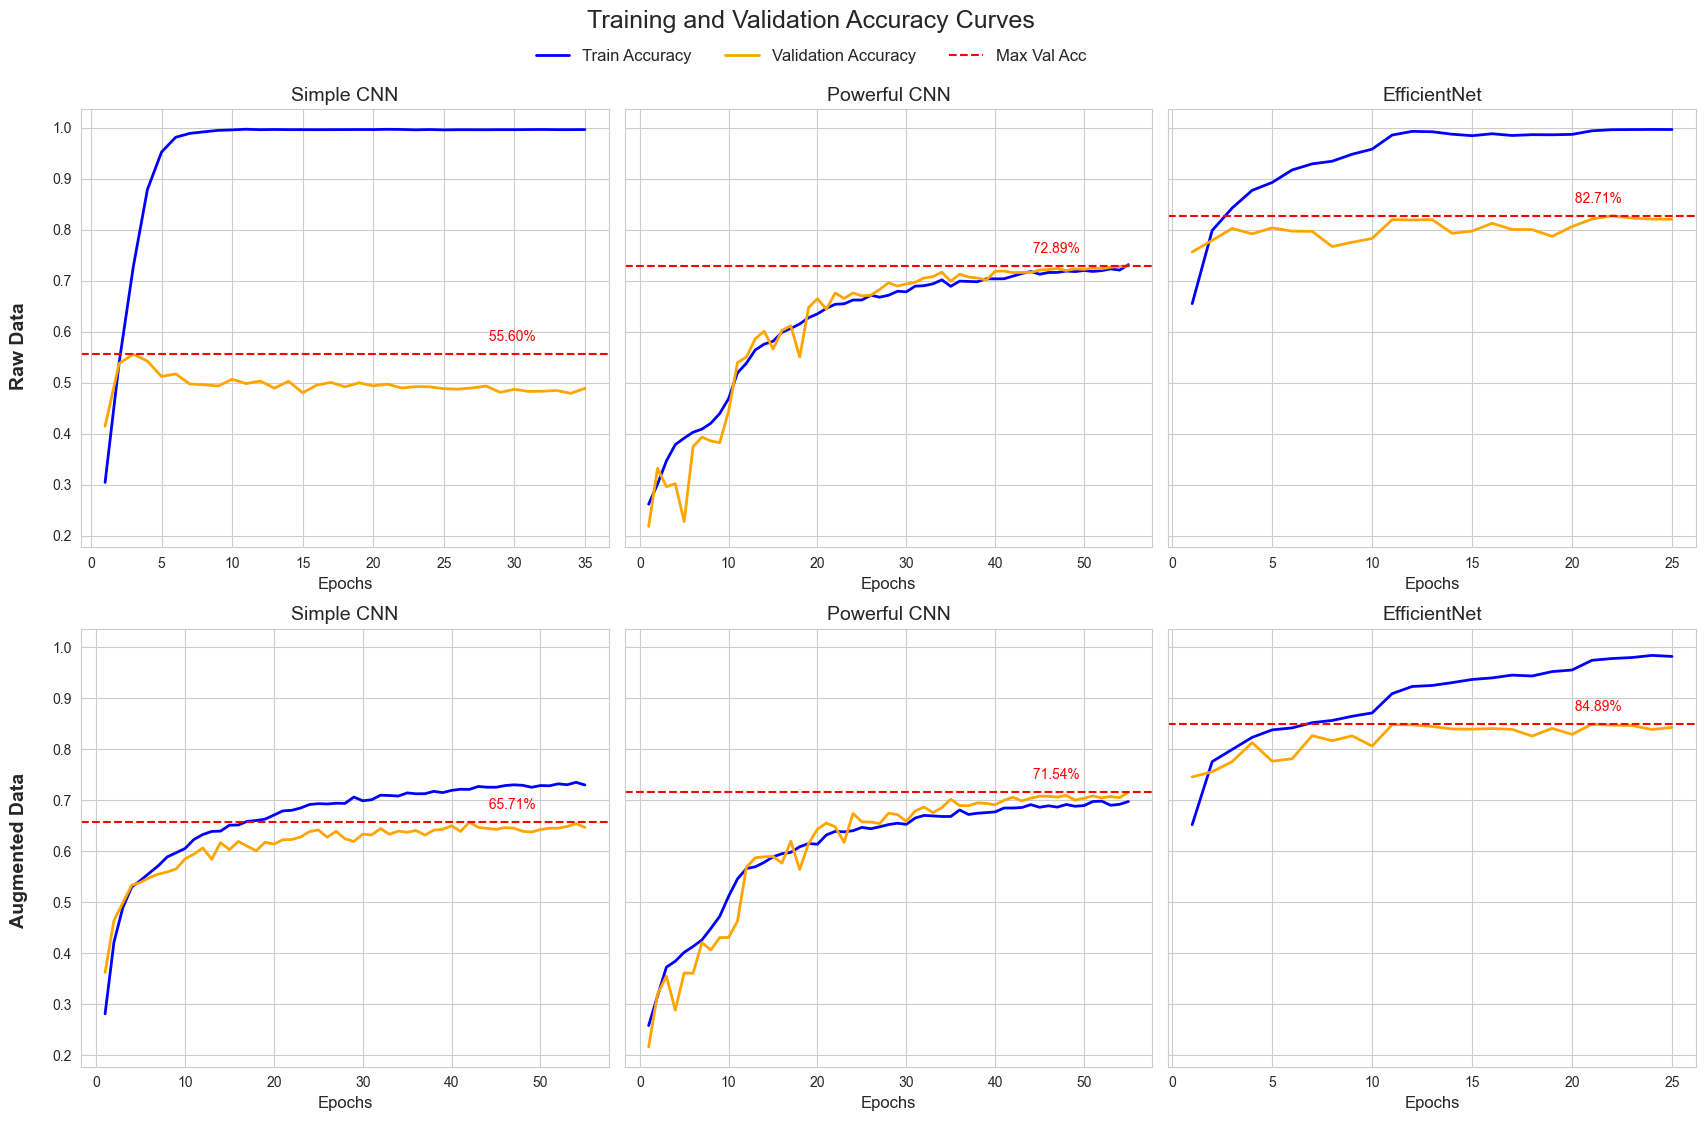

In [41]:
sns.set_style("whitegrid")

log_files = {
    ('raw', 'simple_cnn'):         "logs/experiment_simple_cnn_raw.csv",
    ('raw', 'powerful_cnn'):       "logs/experiment_powerful_cnn_raw.csv",
    ('raw', 'efficient_net'):      "logs/experiment_efficient_net_raw.csv",
    ('augmented', 'simple_cnn'):   "logs/experiment_simple_cnn_augmented.csv",
    ('augmented', 'powerful_cnn'): "logs/experiment_powerful_cnn_augmented.csv",
    ('augmented', 'efficient_net'):"logs/experiment_efficient_net_augmented.csv",
}

name_map = {
    'simple_cnn':   "Simple CNN",
    'powerful_cnn': "Powerful CNN",
    'efficient_net':"EfficientNet"
}
data_map = {
    'raw':       "Raw",
    'augmented': "Augmented"
}

fig, axes = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(18,12))

# The two data types (rows) and three model variants (columns)
data_types = ['raw', 'augmented']
models = ['simple_cnn', 'powerful_cnn', 'efficient_net']

for i, data_type in enumerate(data_types):
    for j, model in enumerate(models):
        filepath = log_files[(data_type, model)]
        df = pd.read_csv(filepath)
        
        epochs   = df['epoch']
        train_acc= df['train_acc']
        val_acc  = df['val_acc']
        
        ax = axes[i, j]
        ax.plot(epochs, train_acc, label='Train Accuracy', color='blue', linewidth=2)
        ax.plot(epochs, val_acc, label='Validation Accuracy', color='orange', linewidth=2)
        
        # Compute max validation accuracy and draw a dashed horizontal line
        max_val = val_acc.max()
        ax.axhline(max_val, linestyle='--', color='red', linewidth=1.5, label='Max Val Acc')
        
        offset = 0.02  
        ax.text(epochs.iloc[-1]*0.9, max_val + offset, f" {max_val:.2%}", 
                color='red', fontsize=10, va='bottom', ha='right')

        ax.set_xlabel("Epochs", fontsize=12)
        ax.set_title(f"{name_map[model]}", fontsize=14)
        ax.grid(True)
        

fig.text(0.06, 0.7, "Raw Data", va="center", ha="center", rotation=90, fontsize=14, fontweight="bold")
fig.text(0.06, 0.28, "Augmented Data", va="center", ha="center", rotation=90, fontsize=14, fontweight="bold")
plt.suptitle("Training and Validation Accuracy Curves", fontsize=18, y=0.98)

# Create a single overall legend, using dummy line objects.
line_train, = axes[0,0].plot([], [], label="Train Accuracy", color='blue', linewidth=2)
line_val,   = axes[0,0].plot([], [], label="Validation Accuracy", color='orange', linewidth=2)
line_max,   = axes[0,0].plot([], [], linestyle='--', label="Max Val Acc", color='red', linewidth=1.5)
fig.legend([line_train, line_val, line_max],
           ["Train Accuracy", "Validation Accuracy", "Max Val Acc"],
           loc="upper center", bbox_to_anchor=(0.5, 0.96),
           ncol=3, fontsize=12, frameon=False)

plt.tight_layout(rect=[0.07, 0.05, 1, 0.96])
plt.savefig("plots/training_validation_accuracy_curves.png", dpi=300, bbox_inches='tight')
plt.show()

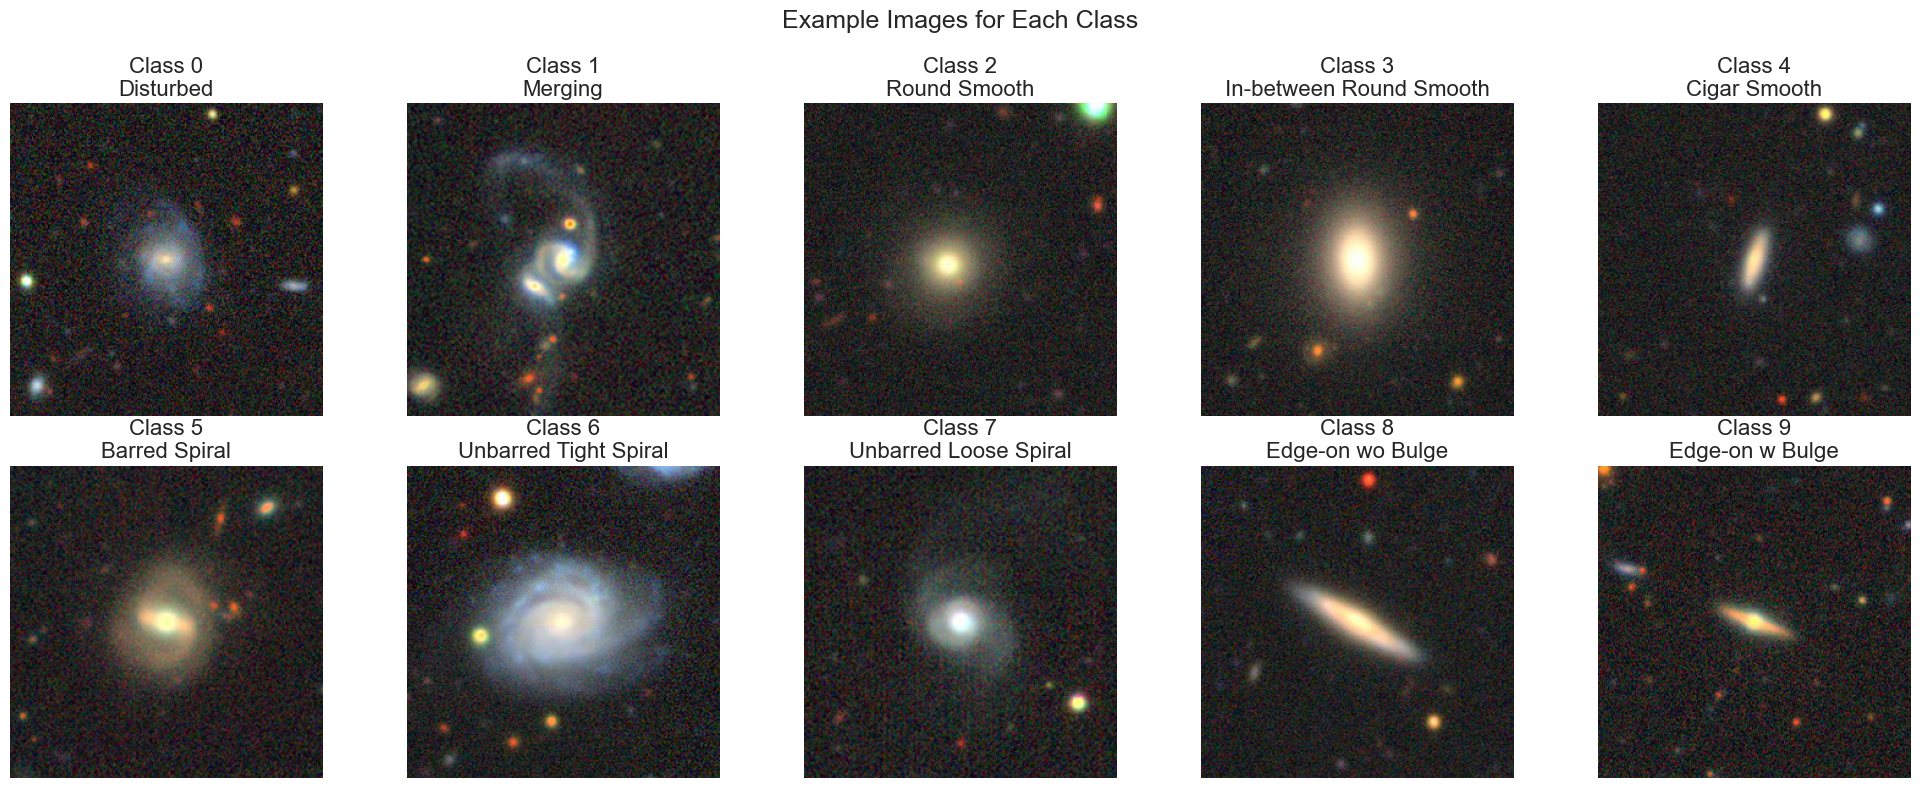

In [54]:
class_names = ['Disturbed', 'Merging', 'Round Smooth', 'In-between Round Smooth', 
           'Cigar Smooth', 'Barred Spiral', 'Unbarred Tight Spiral', 
           'Unbarred Loose Spiral', 'Edge-on wo Bulge', 'Edge-on w Bulge']

# Unnormalize helper: assumes ImageNet normalization used during testing
def unnormalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    img: tensor shape (3, H, W)
    Returns a numpy array (H, W, 3) in [0,1].
    """
    img = img.clone().cpu()  # detach if on GPU
    for t, m, s in zip(range(3), mean, std):
        img[t] = img[t] * s + m
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))
    img = np.clip(img, 0, 1)
    return img

# Randomly sample one example image for each class from the test dataset.
examples = {}  # dictionary mapping class (0,...,9) to image tensor

for cls in range(10):
    # Get a list of indices for which the label equals the current class.
    indices = [i for i in range(len(test_dataset)) if test_dataset[i][1] == cls]
    if indices:  # if there is at least one example for that class
        idx = random.choice(indices)  # randomly choose one
        examples[cls] = test_dataset[idx][0]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axes = axes.flatten()

for cls in range(10):
    ax = axes[cls]
    # Get the example image tensor, unnormalize, and display.
    if cls in examples:
        img_disp = unnormalize(examples[cls])
        ax.imshow(img_disp)
        ax.set_title(f"Class {cls}\n{class_names[cls]}", fontsize=16)
    else:
        ax.text(0.5, 0.5, "No example", ha='center', va='center')
    ax.axis('off')

plt.suptitle("Example Images for Each Class", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig("plots/example_galaxy_images.png", dpi=300, bbox_inches='tight')
plt.show()

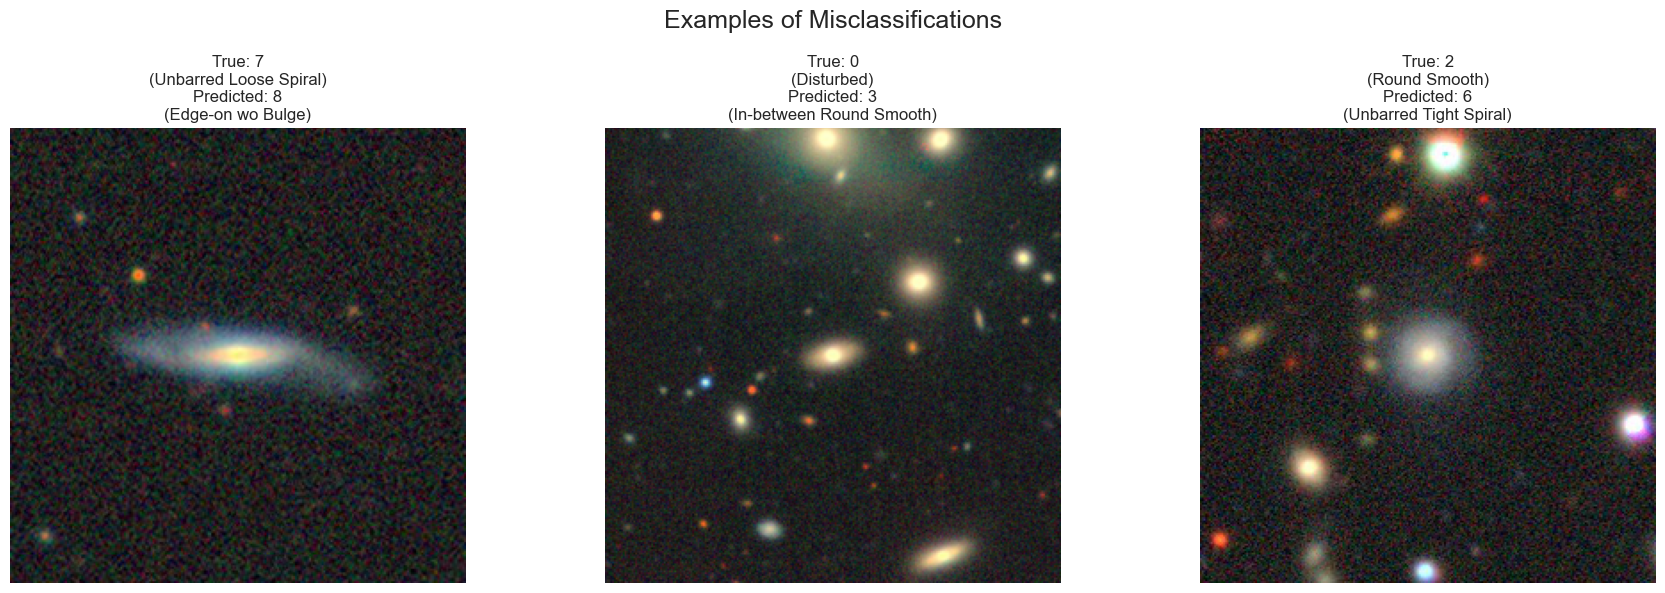

In [50]:
# Collect indices of misclassified examples.
misclassified = [(idx, label, all_preds[idx]) 
                 for idx, (img, label) in enumerate(test_dataset) 
                 if all_preds[idx] != label]

# Shuffle and then take 3 random misclassified examples.
random.shuffle(misclassified)
misclassified_samples = misclassified[:3]

# Create a 1x3 figure for misclassifications.
fig, axes = plt.subplots(ncols=3, figsize=(18, 6))

for i, (idx, true_label, pred_label) in enumerate(misclassified_samples):
    ax = axes[i]
    image, _ = test_dataset[idx]
    img_disp = unnormalize(image)
    ax.imshow(img_disp)
    ax.set_title(
        f"True: {true_label}\n({class_names[true_label]})\nPredicted: {pred_label}\n({class_names[pred_label]})",
        fontsize=12
    )
    ax.axis('off')

plt.suptitle("Examples of Misclassifications", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("plots/misclassified_galaxy_images.png", dpi=300, bbox_inches='tight')
plt.show()

Top 3 predicted classes: [6, 2, 7]


/opt/anaconda3/envs/mldl/lib/python3.12/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


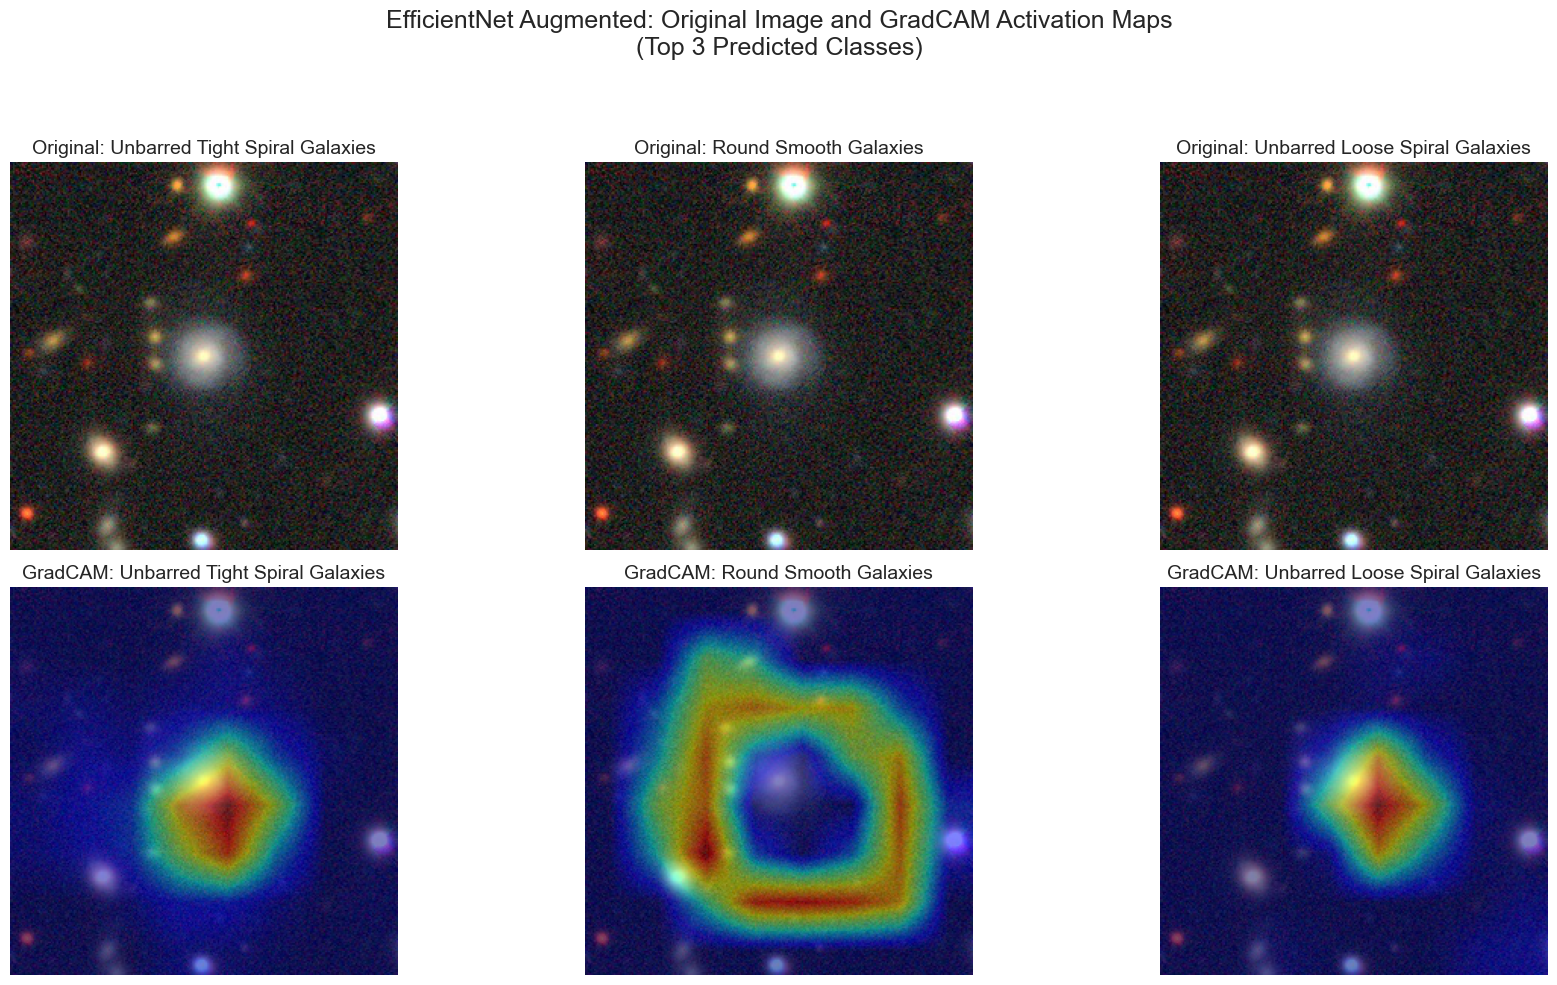

In [56]:
# --- GradCAM class for Saliency Map (Extra just for vibes)---
class GradCAM:
    def __init__(self, model, target_layer):
        """
        model: neural network model.
        target_layer: the module from which to extract features.
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()
        
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))
        
    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()
            
    def __call__(self, input_tensor, target_class):
        """
        Computes GradCAM for the input_tensor for the given target_class.
        input_tensor: tensor of shape [1,3,H,W].
        target_class: integer, the target class.
        Returns:
            A CAM tensor of shape [1,1,H,W] normalized to [0,1].
        """
        output = self.model(input_tensor)
        score = output[0, target_class]
        self.model.zero_grad()
        score.backward(retain_graph=True)
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        return cam

# --- Unnormalize helper function ---
def unnormalize_image(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    img = tensor.clone().cpu()
    for t, m, s in zip(range(3), mean, std):
        img[t] = img[t] * s + m
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))
    img = np.clip(img, 0, 1)
    return img

# --- Model loading ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_efficientnet(model_name='efficientnet_b2', num_classes=10, pretrained=True)
checkpoint_path = 'trained_models/best_efficient_net_augmented.pth'
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model = model.to(device)
model.eval()

# Set the target layer – for EfficientNet from timm, 'conv_head' is often a good candidate.
target_layer = model.conv_head  
gradcam = GradCAM(model, target_layer)

# --- Select a random image from test_dataset ---
sample_idx = random.choice(range(len(test_dataset)))
sample_img, sample_label = test_dataset[sample_idx]  # sample_img: tensor, sample_label: int
input_tensor = sample_img.unsqueeze(0).to(device)

# Get the original image (unnormalized) for display.
orig_img = unnormalize_image(sample_img)

# --- Get top-3 predictions ---
with torch.no_grad():
    output = model(input_tensor)
    probs = torch.softmax(output, dim=1)
    top3 = torch.topk(probs, 3)
    target_classes = top3.indices[0].tolist()  # top 3 predicted classes

class_names = [
    'Disturbed Galaxies', 'Merging Galaxies', 'Round Smooth Galaxies',
    'In-between Round Smooth Galaxies', 'Cigar Smooth Galaxies', 
    'Barred Spiral Galaxies', 'Unbarred Tight Spiral Galaxies', 
    'Unbarred Loose Spiral Galaxies', 'Edge-on wo Bulge', 'Edge-on w Bulge'
]

print("Top 3 predicted classes:", target_classes)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

for i, target_class in enumerate(target_classes):
    # Top row: original image
    ax_orig = axes[0, i]
    ax_orig.imshow(orig_img)
    ax_orig.set_title(f"Original: {class_names[target_class]}", fontsize=14)
    ax_orig.axis('off')
    
    # Bottom row: GradCAM overlay
    ax_cam = axes[1, i]
    cam = gradcam(input_tensor, target_class)  # shape: [1,1,H,W]
    cam_np = cam.squeeze().cpu().numpy()        # shape: [H,W]
    
    # Convert the heatmap to an RGB image using a colormap (e.g., jet).
    heatmap = plt.cm.jet(cam_np)[..., :3]  # Use only RGB channels.
    overlay = 0.5 * orig_img + 0.5 * heatmap  # Blend original and heatmap.
    
    ax_cam.imshow(overlay)
    ax_cam.set_title(f"GradCAM: {class_names[target_class]}", fontsize=14)
    ax_cam.axis('off')

plt.suptitle("EfficientNet Augmented: Original Image and GradCAM Activation Maps\n(Top 3 Predicted Classes)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

# Remove hooks when done.
gradcam.remove_hooks()